# Шкарбаненко Михаил,  Б05-907

# Задача 1. Анализ модели CNN

Провести анализ качества аппроксимации выборки EMNIST-letters моделью сверточной нейронной сети в зависимости от:

размера ядра (можно ввести ограничение, что на каждом слое размер ядра одинаковый);
числа слоев;
от пулинга;
добавления BatchNorm;
параметра dropout.
Все выводы должны быть представленны в формате tensorboard (каждый набор параметров, свой график, пример 16-й семинар).

P.S. Выборку можно взять из torchvision.

P.S.S Если не работает скачиваение EMNIST использовать FahionMnist.

Пояснение: В данном задании важно продемонстрировать умение строить различные структуры модели CNN. Не обязательно выполнять перебор всех вариантов нейросети (проходить по сетке гиперпараметров), но описание экспериментов должны присутвовать.

## 1. Подготовительная часть

### Библиотеки

In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
from urllib.request import urlopen
from skimage.segmentation import mark_boundaries

from tqdm.notebook import tqdm
import numpy as np
import requests
import torch
import math

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext tensorboard

### Девайс

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

### Код для обучения модели

In [5]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()
    
    output = model(x_batch.to(device))
    
    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [6]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [7]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

### Логгер

In [8]:
class Callback():
    def __init__(self, writer, dataset, loss_function, delimeter=100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            self.writer.add_graph(model, self.dataset[0][0].view(1,1,28,28).to(model.device))
            
            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset, 
                                                          batch_size=self.batch_size)
            
            pred = []
            real = []
            test_loss = 0
            for it, (x_batch, y_batch) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)
                y_batch = y_batch.to(model.device)

                with torch.no_grad():

                    output = model(x_batch)

                test_loss += self.loss_function(output, y_batch).cpu().item()*len(x_batch)

                pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
                real.extend(y_batch.cpu().numpy().tolist())
            
            test_loss /= len(self.dataset)
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
            self.writer.add_text('REPORT/test', str(classification_report(real, pred)), self.step)
            
            x = x_batch[-10:].to(model.device)
            y = model.layers.CONV1_conv(x)
            num_images = 5
            if model.num_conv_layers != 1:
                z = model.layers[0:model.conv_layer_size+1](x)
                num_images += 16
            fig = plt.figure(figsize=(30, 15))
            gs = gridspec.GridSpec(10, num_images)
            ax = np.empty([10, num_images], dtype=object)
            for i in range(len(x)):
                for j in range(num_images):
                    ax[i][j] = fig.add_subplot(gs[i, j])
                    ax[i][j].axis("off")
            for i in range(len(x)):
                ax[i][0].imshow(x.cpu().data[i, 0].numpy())
                for j in range(1, 5):
                    ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
                for j in range(5, num_images):
                    ax[i][j].imshow(z.cpu().data[i, j-5].numpy())
            self.writer.add_figure('CNN/convs', fig, self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

### Конструктор архитектуры нейросети

In [9]:
def add_conv_layer(layers, img_length, layer_num, in_channels, out_channels, \
                   conv_ks, pool_ks, dropout, batchnorm):
    layer_num = 'CONV' + str(layer_num) + '_'
    layers.add_module(layer_num + 'conv', torch.nn.Conv2d(in_channels, out_channels, kernel_size=conv_ks))
    img_length = max(img_length - conv_ks + 1, 0)
    if dropout:
        layers.add_module(layer_num + 'dropout', torch.nn.Dropout())
    if batchnorm:
        layers.add_module(layer_num + 'batchnorm' + layer_num, torch.nn.BatchNorm2d(out_channels))
    layers.add_module(layer_num + 'maxpool', torch.nn.MaxPool2d(kernel_size=pool_ks))
    img_length = (img_length - pool_ks) // pool_ks + 1
    layers.add_module(layer_num + 'relu', torch.nn.ReLU())
    return img_length

def add_lin_layer(layers, layer_num, in_size, out_size):
    layer_num = 'LIN' + str(layer_num) + ' '
    layers.add_module(layer_num + 'lin', torch.nn.Linear(in_size, out_size))        
    layers.add_module(layer_num + 'relu', torch.nn.ReLU())
    
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self, conv_ks=3, pool_ks=2, num_conv_layers=1, num_lin_layers=1, \
                 batchnorm=False, dropout=False, num_classes=26, img_length=28):
        super(CNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.conv_layer_size = 3 + int(batchnorm) + int(dropout)
        self.layers = torch.nn.Sequential()
        in_channels, out_channels = 1, 4
        for i in range(1, num_conv_layers+1):
            img_length = add_conv_layer(self.layers, img_length, i, in_channels, out_channels, \
                                        conv_ks, pool_ks, dropout, batchnorm)
            print(img_length)
            in_channels, out_channels = out_channels, out_channels*4
        self.layers.add_module('flatten', torch.nn.Flatten())
        in_size = int(img_length * img_length * (4 ** num_conv_layers))
        out_size = 120
        for i in range(1, num_lin_layers+1):
            add_lin_layer(self.layers, i, in_size, out_size)
            in_size = out_size
            out_size = in_size
        self.layers.add_module('output lin', torch.nn.Linear(out_size, num_classes))
        self.layers.add_module('softmax', torch.nn.Softmax())

    def forward(self, input):
        return self.layers(input)

### Датасет

In [10]:
EMNIST_train = datasets.EMNIST(root='./emnist_data/', split='letters', train=True, download=True, 
                             transform=transforms.ToTensor())

EMNIST_test = datasets.EMNIST(root='./emnist_data/', split='letters', train=False, download=True,
                            transform=transforms.ToTensor())

## 2. Основная часть. Анализ перфоманса модели в зависимости от параметров архитектуры

In [11]:
def show_images(images, preds=None):
    n = len(images[0])
    fig, axs = plt.subplots(2, math.ceil(n/2), figsize=(18, 7))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[0][i].permute(1, 2, 0))
        ax.set_xticks([])
        ax.set_yticks([])
        if preds is not None:
            target = images[1][i] 
            pred = torch.argmax(preds[i])
            conf = preds[i][pred]
            ax.set_title("target: {} pred: {} conf: {}%".format(target, pred, round(conf.item()*100, 1)))
    fig.subplots_adjust(hspace=0.01)

In [12]:
def make_experiment(log_dir, conv_ks=3, pool_ks=2, num_conv_layers=1, num_lin_layers=1, batchnorm=False, dropout=False):
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam
    model = CNN(conv_ks, pool_ks, num_conv_layers, num_lin_layers, batchnorm, dropout).to(device)
    log_dir = log_dir
    writer = SummaryWriter(log_dir = log_dir)
    call = Callback(writer, EMNIST_test, loss_function)
    trainer(count_of_epoch = 5,
            batch_size = 64,
            dataset = EMNIST_train,
            model = model,
            loss_function = loss_function,
            optimizer = optimizer,
            lr = 0.001,
            callback = call)

### 2.0 Пример работы модели до и после обучения на случайном сэмпле картинок 

### Базовая конфигурация модели

In [13]:
model = CNN().to(device)
model

13


CNN(
  (layers): Sequential(
    (CONV1_conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (CONV1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (CONV1_relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (LIN1 lin): Linear(in_features=676, out_features=120, bias=True)
    (LIN1 relu): ReLU()
    (output lin): Linear(in_features=120, out_features=26, bias=True)
    (softmax): Softmax(dim=None)
  )
)

#### До

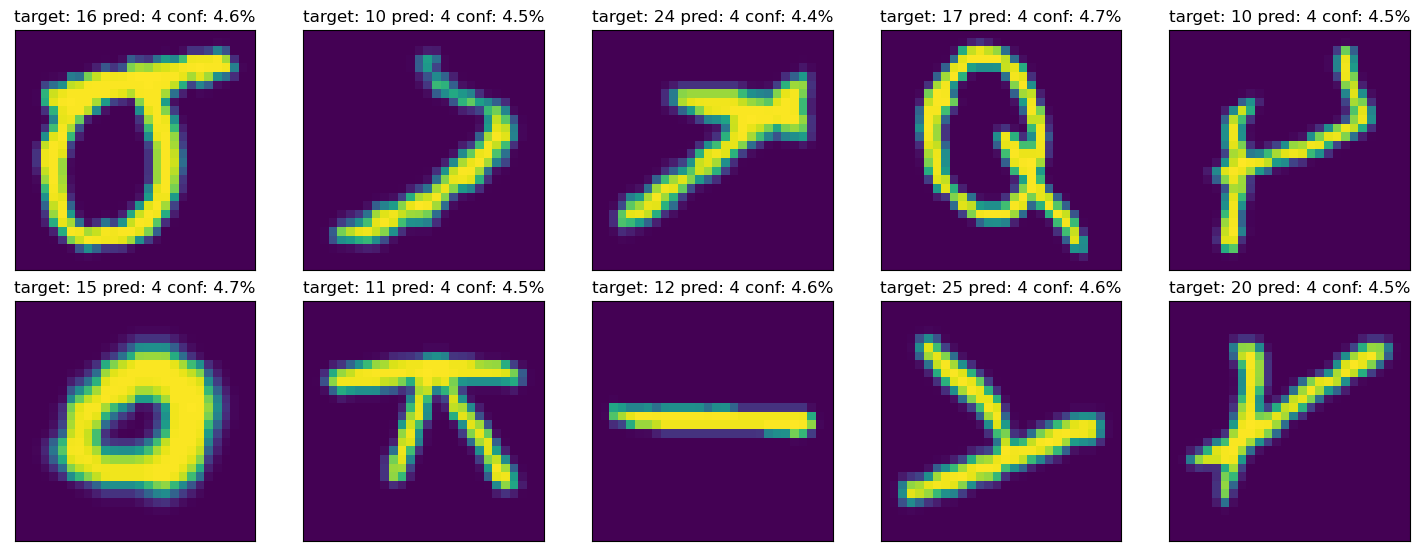

In [14]:
sample_loader = torch.utils.data.DataLoader(dataset=EMNIST_test, batch_size=10, shuffle=True)
images = next(iter(sample_loader))  
preds = model(images[0].to(device)).to('cpu')
show_images(images, preds)

#### После

In [15]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
model = CNN().to(device)
log_dir = 'logs/exp 2.0 - perfomance with basic conf/'
writer = SummaryWriter(log_dir = log_dir)
call = Callback(writer, EMNIST_test, loss_function)
trainer(count_of_epoch = 5,
        batch_size = 64,
        dataset = EMNIST_train,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)

13


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

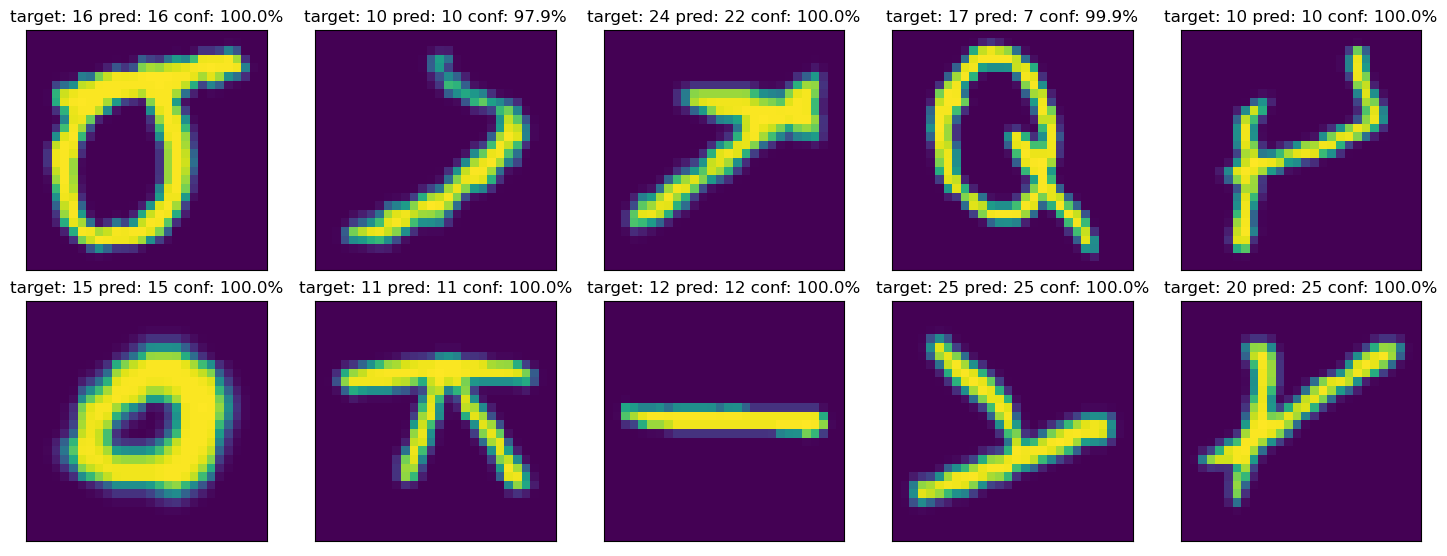

In [16]:
preds = model(images[0].to(device))
show_images(images, preds)

Видно, что до обучения веса инициализировались рандомным образом и модель выдавала случайные предикт. После обучения модель в среднем распознает 9 картинок из 10 при случайном сэмплировании.

### 2.1 Варьирование размера ядра свертки 

In [17]:
for size in [2, 4, 5]:
    log_dir = 'logs/exp 2.1 - conv kernel size/kernel_size = ' + str(size)
    make_experiment(log_dir, conv_ks=size)

13


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

13


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

12


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

12


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

### 2.2 Варьирование размера ядра пуллинга

In [18]:
for size in [3, 4, 5]:
    log_dir = 'logs/exp 2.2 - pool kernel size/kernel_size = ' + str(size)
    make_experiment(log_dir, pool_ks=size)

8


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

6


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

5


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

### 2.3 Варьирование числа сверточных слоев

In [19]:
for n in [2, 3]:
    log_dir = 'logs/exp 2.3 - num conv layers/num layers = ' + str(n)
    make_experiment(log_dir, num_conv_layers=n)

13
5


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

13
5
1


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

### 2.4 Варьирование числа линейных слоев

In [20]:
for n in [2, 3]:
    log_dir = 'logs/exp 2.4 - num lin layers/num layers = ' + str(n)
    make_experiment(log_dir, num_lin_layers=n)

13


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

13


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

### 2.5 Добавление Batchnorm

In [21]:
log_dir = 'logs/exp 2.5 - batchnorm/'
make_experiment(log_dir, batchnorm=True)

13


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

### 2.6 Добавление Dropout

In [22]:
log_dir = 'logs/exp 2.6 - dropout/'
make_experiment(log_dir, dropout=True)

13


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

## 3. Итоги

Базовая конфигурация сети педставлена в пункте 2.0. Она состоит из одного сверточного и одного линейного слоев и не содержит batchnorm и dropout слоев. В каждом эксперименте изменялся лишь один рассматриваемый параметр конфигурации, а остальные оставались неизменными, чтобы выявить влияние этого конкретного параметра на качество работы модели. Все эксперименты доступны в интерфейсе tensorboard.

Выводы о влиянии каждого из параметров конфигурации на перфоманс сети:

* Convolutional kernel size. Рассматриваемые значения: 2, 3, 4, 5. Наиболеее оптимальный размер ядра оказался равен 4, метрики качества в случае kernel size = 3 - хуже, но незначительно. Наихудший результат модель показала при ядрах размеров 2 и 5. Слишком маленький и слишком большой размеры ядра могут приводить к невозможности распознавать большие и маленькие графические паттерны соответственно. Для каждой пары архитектура/датасет имеет смысл подбирать оптимальное значение этого параметра, если позволяют вычислительные и временные ресурсы.


* Pooling kernel size. Рассматриваемые значения: 2, 3, 4, 5. Лосс на тесте оказался приблизительно одинаковым во всех экспериментах, но метрики качества значительно упали при увеличении размера ядра до 4 и 5. Падение качества ожидаемо и происходит из-за значительной потери информации об исходном изображении при слишком больших размерах ядра пуллинга. Нужен баланс между сжатием и информации и ее полнотой. 


* Number of convolutional layers. Рассматриваемые значения: 1, 2, 3. При добавлении каждого нового сверточного слоя перфоманс модели падал, но это не означает, что сверточные сети с большим количеством сверточных слоев работают хуже. Стоить учитывать специфику датасета - размер картинок довольно малеьнький, а изображения символов занимают почти всю площадь картинки. Каждый новый сверточный слой значительно сжимал информацию, так как содержал в себе и обычную свертку и пуллинг. Но для данного датасета такое сжатие привело лишь к потере данных. Если бы размер изображений был больше, а распознаваемые объекты были бы незначительного размера по сравнению с размером изображения, то дополнительные сверточные слои повысили бы качество работы модели.


* Number of linear layers. Рассматриваемые значения: 1, 2, 3. Перфоманс модели оказался незначительно лучше при использовании классификаторной части из двух линейных слоев, нежели чем из одного слоя. При трех слоях и, вероятно, что при большем количестве тоже, качество работы модели падает. Это может быть связано с двумя факторами: с переобучением - запоминанием  трейн датасета и неудовлетворительным перфомансом на тесте и с затуханием градиентов. 


* Batchnorm. Рассматриваемые варианты: сверточный слой содержит/не содержит batchnorm. Качество сети возросло при добавлении нормализационного слоя. Результат ожидаемый и в большинстве случаев, как показывают многие исследования, добавление batchnorm ведет к улучшению сети.


* Dropout. Рассматриваемые варианты: сверточный слой содержит/не содержит dropout. Качество сети упало при добавлении дропаут слоя. Результат не вполне ожидаемый. Дропаут слой делает сеть более устойчивой, форсируя нейроны обучаться замещать друг друга. Для данного датасета/конфигурации такие возможности сети оказалоись избыточными, но во многих случаев, они могут улучшить результаты.


In [24]:
%tensorboard --logdir='logs/'

Reusing TensorBoard on port 6006 (pid 43168), started 0:08:00 ago. (Use '!kill 43168' to kill it.)